In [38]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn


sizeFixed = (18,18)
channels = 1
#dsImages = "/home/digits/jupyter/chtseng/datasets/office/train"
dsImages = "/home/chtseng/works/train-opencvCascade/datasets/classed/18x18-3-gestures/train"

epoch = 300
batchSize = 72
#testPath = "/home/digits/jupyter/chtseng/datasets/office/test"
testPath = "/home/chtseng/works/train-opencvCascade/datasets/classed/18x18-3-gestures/test"

In [39]:
import os
from keras.models import Sequential # Initialise our neural network model as a sequential network
from keras.layers import Conv2D # Convolution operation
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector.
from keras.layers import Dense # Perform the full connection of the neural network
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import PReLU
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from keras.layers.normalization import BatchNormalization
from datetime import datetime
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dropout
from IPython.display import display
from PIL import Image
from keras.layers import Dense, Dropout
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline

from keras import optimizers
import glob

In [40]:
#Lable的對應, 每個Lable對應到一個數值

#dict_labels = {"nobody": 0,"body": 1, "chair": 2, "head": 3}
#dict_labels = { "none": 0,"sitting": 1, "standing": 2, "walking": 3 }
dict_labels = { "A": 0,"B": 1, "C": 2 }

In [41]:
def reshaped_image(image):
    return transform.resize(image,(sizeFixed[0], sizeFixed[1], channels)) # (cols (width), rows (height)) and don't use np.resize()

def load_images_from_folder(folder):    
    labels = []
    images = []
    
    for folders in glob.glob(folder+"/*"):
        #print("Load {} ...".format(folders))
        label = os.path.basename(folders)

        for filename in os.listdir(folders):  

            if label is not None:
                #print(dict_labels[label])
                img = cv2.imread(os.path.join(folder,folders,filename))
                if img is not None:            
                    img = reshaped_image(img)
                    labels.append(dict_labels[label])
                    images.append(np.array(img))
                    
    return np.array(images), np.array(labels)

def train_test_split(train_data, train_labels, fraction):
    index = int(len(train_data)*fraction)
    return train_data[:index], train_labels[:index], train_data[index:], train_labels[index:]

In [42]:
def cnnModel(size, n_layers):

    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN
    # Define hyperparamters

    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    # Define a model
    model = Sequential()
    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))

        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Dropout(rate=0.25))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Add output layer
    model.add(Dense(len(dict_labels)))
    model.add(Activation('relu'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [43]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [44]:
def mnist1(size):
    import keras
    
    shape = (size[0], size[1], size[2])
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=shape))
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.20))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(len(dict_labels), activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

def mnist2(size):
    from keras.optimizers import RMSprop
    # Set the CNN model 
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    shape = (size[0], size[1], size[2])
    
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = shape))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))    
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(len(dict_labels), activation = "softmax"))
    
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [45]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

train_data, train_labels = load_images_from_folder(dsImages)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

fraction = 0.85
print("{}".format(train_data.shape))
print("{}".format(train_labels.shape))
train_data, train_labels, test_data, test_labels = train_test_split(train_data, train_labels, fraction)
datagen.fit(train_data)
#datagen.fit(test_data)

print("--> {}".format( test_data.shape))
print("--> {}".format( test_labels.shape))

train_labels = np_utils.to_categorical(train_labels, len(dict_labels))
test_labels = np_utils.to_categorical(test_labels, len(dict_labels))

train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0
print ("Train data size: ", len(train_data))
print ("Test data size: ", len(test_data))

cnn = mnist2(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]))
#cnn = cnnModel(size=np.asarray([sizeFixed[0], sizeFixed[1], channels]), n_layers=2)
#cnn = SqueezeNet(len(dict_labels), input_shape=([sizeFixed[0], sizeFixed[1], 3]))

#Resnet
#cnn = ResnetBuilder.build_resnet_101((3, sizeFixed[0], sizeFixed[1]), len(dict_labels))
#cnn.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])
#end Resnet

#VGG16
#cnn = VGG16([sizeFixed[0], sizeFixed[1]], len(dict_labels), trained=False)


print ("Train data shape: ", train_data.shape)
print ("Test data shape: ", test_data.shape)
#idx = np.random.permutation(train_data.shape[0])
#print("idx=", idx)

#cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize), 
    #steps_per_epoch=round(len(train_data)/batchSize),epochs=epoch, validation_data=(test_data, test_labels))

h = cnn.fit_generator(datagen.flow(train_data,train_labels, batch_size=batchSize),
                              epochs = epoch, validation_data = (test_data,test_labels),
                              verbose = 1, steps_per_epoch=train_data.shape[0] // batchSize
                              , callbacks=[learning_rate_reduction],)

(6762, 18, 18, 1)
(6762,)
--> (1015, 18, 18, 1)
--> (1015,)
Train data size:  5747
Test data size:  1015
Train data shape:  (5747, 18, 18, 1)
Test data shape:  (1015, 18, 18, 1)
Epoch 1/300
79/79 [==============================] - 11s 139ms/step - loss: 1.0709 - acc: 0.3941 - val_loss: 1.6203 - val_acc: 0.0000e+00
Epoch 2/300
79/79 [==============================] - 11s 133ms/step - loss: 1.0578 - acc: 0.3986 - val_loss: 1.8068 - val_acc: 0.0000e+00
Epoch 3/300
79/79 [==============================] - 11s 133ms/step - loss: 1.0575 - acc: 0.4022 - val_loss: 1.4716 - val_acc: 0.0000e+00
Epoch 4/300
79/79 [==============================] - 10s 133ms/step - loss: 1.0461 - acc: 0.4245 - val_loss: 1.3861 - val_acc: 0.0000e+00

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/300
79/79 [==============================] - 11s 133ms/step - loss: 1.0107 - acc: 0.4588 - val_loss: 1.4586 - val_acc: 0.0000e+00
Epoch 6/300
79/79 [==============================] 

Epoch 58/300
79/79 [==============================] - 11s 133ms/step - loss: 0.6286 - acc: 0.7326 - val_loss: 1.1390 - val_acc: 0.4463
Epoch 59/300
79/79 [==============================] - 11s 133ms/step - loss: 0.6274 - acc: 0.7322 - val_loss: 0.9869 - val_acc: 0.5064
Epoch 60/300
79/79 [==============================] - 11s 133ms/step - loss: 0.6270 - acc: 0.7308 - val_loss: 1.0667 - val_acc: 0.4611
Epoch 61/300
79/79 [==============================] - 10s 132ms/step - loss: 0.6269 - acc: 0.7383 - val_loss: 1.1807 - val_acc: 0.3892
Epoch 62/300
79/79 [==============================] - 10s 133ms/step - loss: 0.6251 - acc: 0.7321 - val_loss: 1.0904 - val_acc: 0.4502
Epoch 63/300
79/79 [==============================] - 11s 133ms/step - loss: 0.6073 - acc: 0.7483 - val_loss: 1.0979 - val_acc: 0.4631
Epoch 64/300
79/79 [==============================] - 10s 133ms/step - loss: 0.6199 - acc: 0.7422 - val_loss: 0.9812 - val_acc: 0.5271
Epoch 65/300
79/79 [==============================] - 1

79/79 [==============================] - 10s 133ms/step - loss: 0.4982 - acc: 0.7977 - val_loss: 0.8943 - val_acc: 0.5803
Epoch 119/300
79/79 [==============================] - 11s 133ms/step - loss: 0.5043 - acc: 0.7887 - val_loss: 0.7424 - val_acc: 0.6542
Epoch 120/300
79/79 [==============================] - 11s 133ms/step - loss: 0.4991 - acc: 0.7925 - val_loss: 1.0692 - val_acc: 0.5281
Epoch 121/300
79/79 [==============================] - 10s 133ms/step - loss: 0.5006 - acc: 0.7886 - val_loss: 0.9498 - val_acc: 0.5655
Epoch 122/300
79/79 [==============================] - 10s 133ms/step - loss: 0.4929 - acc: 0.8029 - val_loss: 0.9050 - val_acc: 0.5892
Epoch 123/300
79/79 [==============================] - 10s 133ms/step - loss: 0.4742 - acc: 0.8098 - val_loss: 0.9276 - val_acc: 0.5734
Epoch 124/300
79/79 [==============================] - 10s 133ms/step - loss: 0.4992 - acc: 0.7944 - val_loss: 0.8171 - val_acc: 0.6246
Epoch 125/300
79/79 [==============================] - 11s 133

79/79 [==============================] - 11s 133ms/step - loss: 0.3680 - acc: 0.8550 - val_loss: 0.3896 - val_acc: 0.8286
Epoch 179/300
79/79 [==============================] - 11s 134ms/step - loss: 0.3606 - acc: 0.8583 - val_loss: 0.7491 - val_acc: 0.6759
Epoch 180/300
79/79 [==============================] - 11s 134ms/step - loss: 0.3599 - acc: 0.8578 - val_loss: 0.6544 - val_acc: 0.7044
Epoch 181/300
79/79 [==============================] - 11s 134ms/step - loss: 0.3601 - acc: 0.8622 - val_loss: 0.5869 - val_acc: 0.7300
Epoch 182/300
79/79 [==============================] - 11s 134ms/step - loss: 0.3637 - acc: 0.8562 - val_loss: 0.6072 - val_acc: 0.7222
Epoch 183/300
79/79 [==============================] - 11s 133ms/step - loss: 0.3495 - acc: 0.8640 - val_loss: 0.4780 - val_acc: 0.7823
Epoch 184/300
79/79 [==============================] - 11s 134ms/step - loss: 0.3671 - acc: 0.8560 - val_loss: 0.5892 - val_acc: 0.7409
Epoch 185/300
79/79 [==============================] - 11s 133

79/79 [==============================] - 11s 133ms/step - loss: 0.2818 - acc: 0.8928 - val_loss: 0.3114 - val_acc: 0.8749
Epoch 239/300
79/79 [==============================] - 11s 134ms/step - loss: 0.2721 - acc: 0.8976 - val_loss: 0.3967 - val_acc: 0.8236
Epoch 240/300
79/79 [==============================] - 11s 133ms/step - loss: 0.2708 - acc: 0.9007 - val_loss: 0.2908 - val_acc: 0.8906
Epoch 241/300
79/79 [==============================] - 10s 133ms/step - loss: 0.2741 - acc: 0.8967 - val_loss: 0.5164 - val_acc: 0.7507
Epoch 242/300
79/79 [==============================] - 11s 134ms/step - loss: 0.2549 - acc: 0.9031 - val_loss: 0.3266 - val_acc: 0.8739
Epoch 243/300
79/79 [==============================] - 11s 134ms/step - loss: 0.2745 - acc: 0.8978 - val_loss: 0.3047 - val_acc: 0.8857
Epoch 244/300
79/79 [==============================] - 11s 133ms/step - loss: 0.2671 - acc: 0.9004 - val_loss: 0.3125 - val_acc: 0.8828
Epoch 245/300
79/79 [==============================] - 11s 134

79/79 [==============================] - 11s 133ms/step - loss: 0.2018 - acc: 0.9254 - val_loss: 0.1988 - val_acc: 0.9369
Epoch 299/300
79/79 [==============================] - 11s 133ms/step - loss: 0.1972 - acc: 0.9305 - val_loss: 0.1486 - val_acc: 0.9586
Epoch 300/300
79/79 [==============================] - 11s 133ms/step - loss: 0.1980 - acc: 0.9253 - val_loss: 0.1537 - val_acc: 0.9507


In [46]:
final_loss, final_acc = cnn.evaluate(test_data, test_labels, verbose=0)

print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))


Final loss: 0.153675, final accuracy: 0.950739


In [47]:
finaltest_data, finaltest_labels = load_images_from_folder(testPath)
finaltest_labels = np_utils.to_categorical(finaltest_labels, len(dict_labels))

finaltest_data = finaltest_data.astype('float32') / 255.0
predicted_test_labels = np.argmax(cnn.predict(finaltest_data), axis=1)
predicted_test_labels = np_utils.to_categorical(predicted_test_labels, len(dict_labels))

print ("Actual test labels:", finaltest_labels)
print ("Predicted test labels:", predicted_test_labels)
print ("Accuracy score:", accuracy_score(finaltest_labels, predicted_test_labels))

Actual test labels: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Predicted test labels: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Accuracy score: 0.9771528998242531


In [48]:
X_val = finaltest_data
Y_val = finaltest_labels

print(test_data.shape)
print(test_labels.shape)
print(finaltest_data.shape)
print(finaltest_labels.shape)

(1015, 18, 18, 1)
(1015, 3)
(569, 18, 18, 1)
(569, 3)


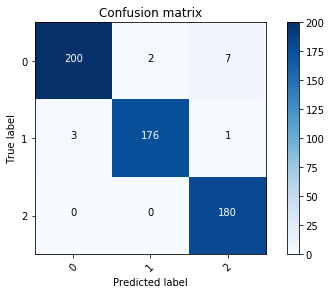

In [49]:


from sklearn.metrics import confusion_matrix
import itertools

# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(len(dict_labels)))

In [50]:
# serialize model to JSON
model_json = cnn.to_json()
with open("gesture_18x18.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("gesture_18x18.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


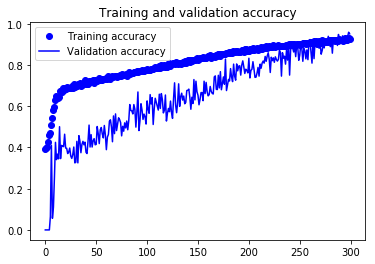

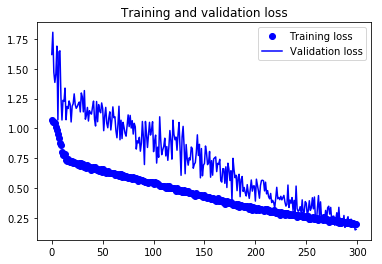

In [51]:


print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

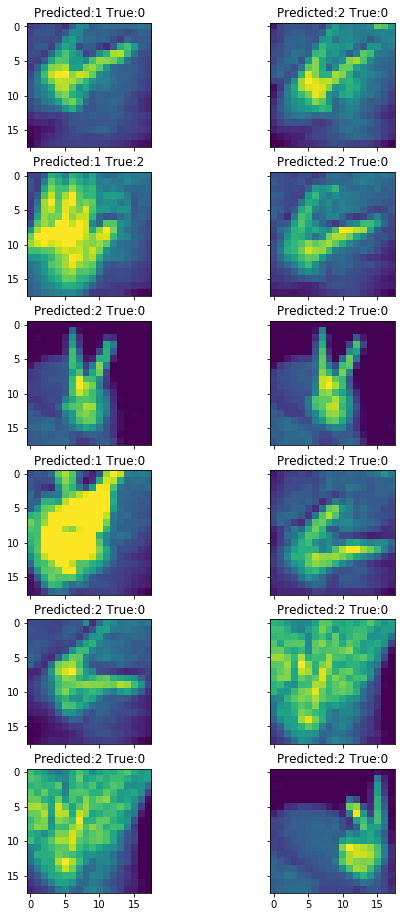

In [103]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

plt.rcParams["figure.figsize"] = [8,16]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 6
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    
    

    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((18,18)))
            ax[row,col].set_title("Predicted:{} True:{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-12:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)